In [4]:
%reload_ext autoreload
%autoreload 2


import numpy as np
from shared.models_store import Store

Using TensorFlow backend.


In [5]:
store = Store(None, '../dist/store.json')
store.load()

configuration = store.configuration
imdb_models = [m for m in configuration.values() if m['metadata']['Dataset'] == 'Internet Movie Database']
food_models = [m for m in configuration.values() if m['metadata']['Dataset'] == 'Amazon Fine Food Reviews']

In [22]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics
from pylab import rcParams
from IPython.core.display import display, HTML
rcParams['figure.figsize'] = 15, 9

def plot_roc_curve(models):
    # calculate the fpr and tpr for all thresholds of the classification
    plt.title('Receiver Operating Characteristic')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    
    for model in models:
        y_test, y_prob = model['metadata']['Y Test'], model['metadata']['Y Pred Proba']
        fpr, tpr, threshold = metrics.roc_curve(y_test, y_prob)
        roc_auc = metrics.auc(fpr, tpr)

        plt.plot(fpr, tpr, label='{} AUC = {}'.format(model['name'], round(roc_auc, 2)))
    
    plt.legend(loc='lower right')
    plt.show()

    
def show_accuracy_summary(models):
    df = pd.DataFrame([{'Name': m['name'], 'Accuracy': m['metadata']['Accuracy']} for m in models])
    display(HTML(df.sort_values('Accuracy', ascending=False).to_html()))
    

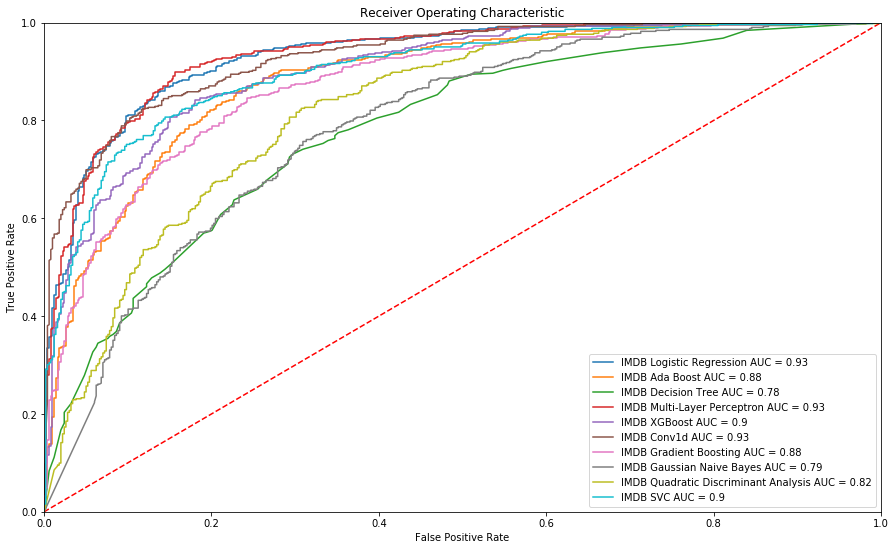

,Accuracy,Name
3,0.862,IMDB Multi-Layer Perceptron
0,0.858,IMDB Logistic Regression
4,0.826,IMDB XGBoost
9,0.825,IMDB SVC
1,0.811,IMDB Ada Boost
6,0.795,IMDB Gradient Boosting
5,0.775,IMDB Conv1d
8,0.720,IMDB Quadratic Discriminant Analysis
2,0.715,IMDB Decision Tree
7,0.701,IMDB Gaussian Naive Bayes


In [23]:
plot_roc_curve(imdb_models)
show_accuracy_summary(imdb_models)

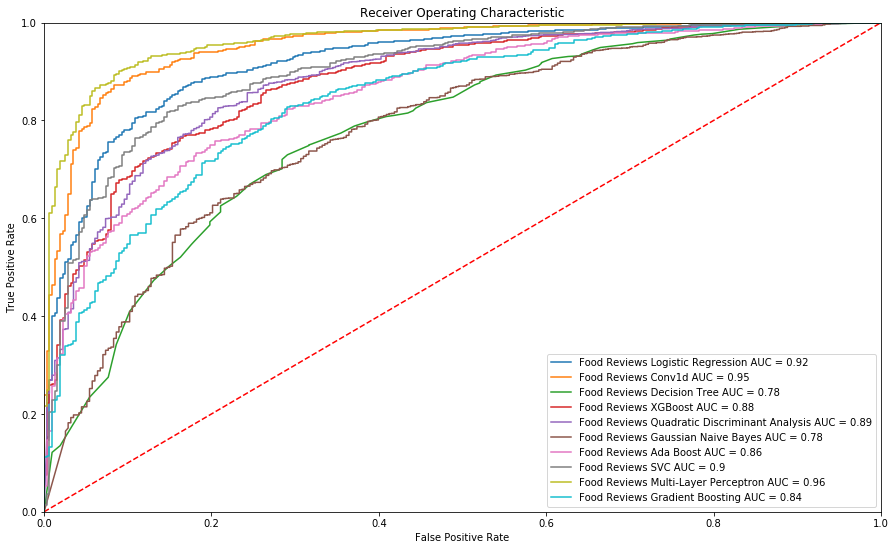

,Accuracy,Name
8,0.9280,Food Reviews Multi-Layer Perceptron
1,0.9090,Food Reviews Conv1d
0,0.8995,Food Reviews Logistic Regression
7,0.8895,Food Reviews SVC
3,0.8785,Food Reviews XGBoost
6,0.8715,Food Reviews Ada Boost
9,0.8665,Food Reviews Gradient Boosting
2,0.8570,Food Reviews Decision Tree
4,0.7885,Food Reviews Quadratic Discriminant Analysis
5,0.6770,Food Reviews Gaussian Naive Bayes


In [24]:
plot_roc_curve(food_models)
show_accuracy_summary(food_models)